# How to Read IMERG Data Using Python
Notebook adapted from [GES DISC Tutorials](https://github.com/nasa/gesdisc-tutorials/). Ensure that you have installed the environment: [gridded_env](../../gridded_environment_readme.md).

---

### 1\. Download the data

Before accessing data at GES DISC, a  user must first register with Earthdata Login, then be authorized to access data at GES DISC by following steps at:  [data-access.](https://disc.gsfc.nasa.gov/information/documents?title=Data%20Access)

- In a web browser, go to: https://disc.gsfc.nasa.gov
- In the Search field, enter GPM_3IMERGM and press enter. Figure 1 shows a screen shot of what the search results look like. 
- Click on the latest version of the GPM_3IMERGM data, currently version 7.
- Click on the ["Online Archive"](https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGM.07/) button on the right.
    - click on the "2009/" folder
    - click on the link "[3B-MO.MS.MRG.3IMERG.20090901-S000000-E235959.09.V07B.HDF5](https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGM.07/2009/3B-MO.MS.MRG.3IMERG.20090901-S000000-E235959.09.V07B.HDF5)" to download the data file.
- **Note:** this recipe works for any IMERG data, not just monthly estimates.

<img src ="https://disc.gsfc.nasa.gov/api/images/GPM_3IMERGM_figure1/file" title="Image1" width=650 height=500 />

**Figure 1:** Example GES DISC search results for GPM_3IMERGM.

Alternatively, for 30-minute data resolution you can register with [NASA Precipitation Processing System (PPS)](https://registration.pps.eosdis.nasa.gov/registration/), and navigate to https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/ using your email address as the username and password.

In case you aren't able to download the file, it is also provided in this folder.

### 2\. Read and plot IMERG data using the cells below
Ensure that you are in gridded_env. Refer to [gridded environmnent documentation](../../gridded_environment_readme.md).

Alternatively, install the h5py package in your preferred environment using the script below. Copy, paste and run the provided script in a new cell. Do not forget the exclamation point.

```bash
!conda install conda-forge::h5py --name meteo203 -y
```


#### Read the data
Imports

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

Open the IMERG data

In [2]:
# It may be necessary to add a path to the filename if it is not in the working directory
fn = '3B-MO.MS.MRG.3IMERG.20090901-S000000-E235959.09.V07B.HDF5'
f = h5py.File(fn, 'r')

In reading hierarchal gridded data, we first try to take a look at the available groups. From the open file `f`, we try to read `f.keys()`

In [3]:
groups = [ x for x in f.keys() ]
print(groups)

['Grid']


For this particular dataset we have `Grid` as the only group. Take note that for other datasets, there may be other groups. For now we proceed with exploring what `Grid` contains. First we print `f['Grid']`.

In [4]:
print(f['Grid'])

<HDF5 group "/Grid" (14 members)>


We see that file `f`, has a group `Grid` with 14 members. Let's now print these 14 members.

In [5]:
gridMembers = [ x for x in f['Grid'] ]
print(gridMembers)

['nv', 'lonv', 'latv', 'time', 'lon', 'lat', 'time_bnds', 'lon_bnds', 'lat_bnds', 'precipitation', 'randomError', 'gaugeRelativeWeighting', 'probabilityLiquidPrecipitation', 'precipitationQualityIndex']


When dissecting hierarchal gridded data, it's always best practice to read the manual. In the case of GPM, most documents can be found in their website [here](https://gpm.nasa.gov/resources/documents). 

But for the purposes of this exercise, we'll be needing the following variables:

- `precipitation`
- `lat`
- `lon`

We can extract these by calling `f['Grid/variable']`. Let's try calling `f['Grid/precipitation']`

In [6]:
print(f['Grid/precipitation'])

<HDF5 dataset "precipitation": shape (1, 3600, 1800), type "<f4">


We see that `f['Grid/precipitation']` has shape (1, 3600, 1800). 

- The first dimension is usually the `time` dimension. For this since we are taking a look at monthly totals, `t=1` for 1 month.
- The second dimenstion `(3600)` is the columns, or `longitude` grid.
- The third dimension `(1800)` is the latitude grid.

Now let's save this in a variable `precip`

In [7]:
precip = f['Grid/precipitation'][0][:][:]

# This step is subtle but important. We transpose the data to ensure that
# it matches the expected (row x column) orientation for plotting with matplotlib,
# rather than the (column x row) storage format commonly found in the raw data.
precip = np.transpose(precip) 

#### Explore and plot the data

Now let's explore the data by printing the array, and then plotting.

[[-9999.9 -9999.9 -9999.9 ... -9999.9 -9999.9 -9999.9]
 [-9999.9 -9999.9 -9999.9 ... -9999.9 -9999.9 -9999.9]
 [-9999.9 -9999.9 -9999.9 ... -9999.9 -9999.9 -9999.9]
 ...
 [-9999.9 -9999.9 -9999.9 ... -9999.9 -9999.9 -9999.9]
 [-9999.9 -9999.9 -9999.9 ... -9999.9 -9999.9 -9999.9]
 [-9999.9 -9999.9 -9999.9 ... -9999.9 -9999.9 -9999.9]]


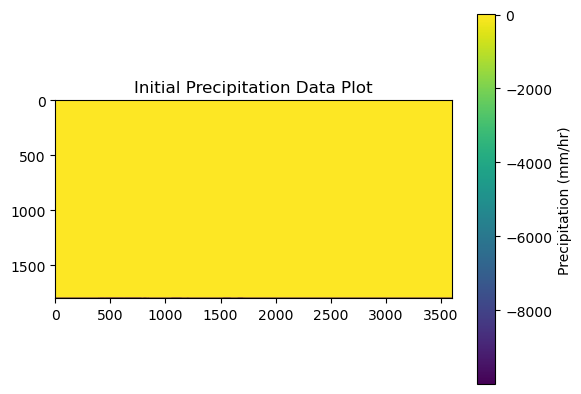

In [8]:
# Print the precipitation data array
print(precip)

# Attempt a basic plot of the precipitation data
plt.imshow(precip)
plt.colorbar(label='Precipitation (mm/hr)')
plt.title("Initial Precipitation Data Plot")
plt.show()


You might notice that the plot doesn’t look quite right yet because we haven’t handled the missing values in the dataset. The data uses `-9999.99` as a fill value to indicate areas with no data, and these values need to be masked.

To mask these fill values, we’ll use `np.ma.masked_values`, which is specifically designed to handle and ignore these values in calculations and plots.

In [9]:
# Mask the fill values in the precipitation data
masked_precip = np.ma.masked_values(precip, -9999.99)

Now that we've masked the invalid data, let's plot.

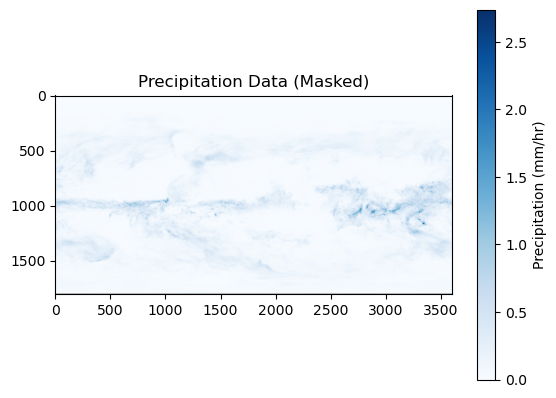

In [10]:
# Plot the precipitation data with masked values
plt.imshow(masked_precip, cmap='Blues')
plt.colorbar(label='Precipitation (mm/hr)')
plt.title("Precipitation Data (Masked)")
plt.show()

#### Calculate basic statistics
Now, let’s calculate some basic statistics to understand the precipitation values better.

In [11]:
mean_precip = masked_precip.mean()
max_precip = masked_precip.max()
min_precip = masked_precip.min()

print("Mean Precipitation:", mean_precip, "mm/hr")
print("Max Precipitation:", max_precip, "mm/hr")
print("Min Precipitation:", min_precip, "mm/hr")


Mean Precipitation: 0.09672626568198639 mm/hr
Max Precipitation: 2.7370002 mm/hr
Min Precipitation: 0.0 mm/hr


For a deeper look, we can calculate the zonal (latitude-wise) and meridional (longitude-wise) means to see how precipitation varies across different latitudes and longitudes.

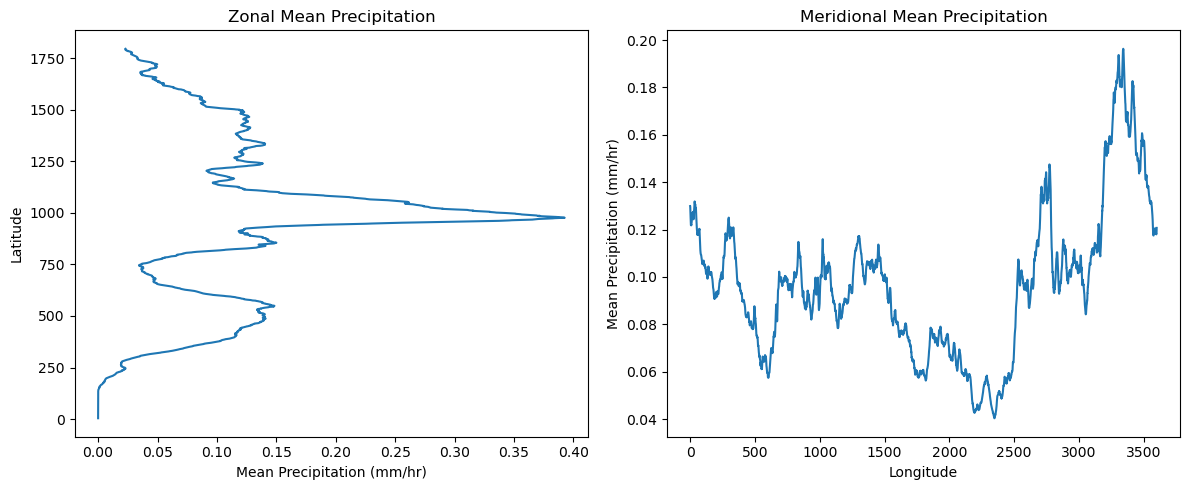

In [12]:
# Zonal (latitude-wise) mean precipitation
zonal_mean = masked_precip.mean(axis=1)

# Meridional (longitude-wise) mean precipitation
meridional_mean = masked_precip.mean(axis=0)

# Plotting zonal and meridional means
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Zonal mean plot
ax1.plot(zonal_mean, range(masked_precip.shape[0]))
ax1.set_title("Zonal Mean Precipitation")
ax1.set_xlabel("Mean Precipitation (mm/hr)")
ax1.set_ylabel("Latitude")

# Meridional mean plot
ax2.plot(range(masked_precip.shape[1]), meridional_mean)
ax2.set_title("Meridional Mean Precipitation")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Mean Precipitation (mm/hr)")

plt.tight_layout()
plt.show()


So far, we've calculated zonal (latitude-wise) means directly using the rows and columns of our precipitation data array. In this approach, each row corresponds to a latitude band, and each column corresponds to a longitude band. While this method works for initial exploration, it treats the grid purely in terms of array positions (i.e., row and column indices) without considering the **actual geographic coordinates**.

To accurately plot our data on a map, we need to align each precipitation value with its **real-world latitude and longitude coordinates**. 

This requires:

1. Extracting Actual Latitude and Longitude:

    - The GPM data includes Grid/lat and Grid/lon, which provide the actual latitude and longitude values for each grid cell. These coordinates allow us to map each grid point to its precise geographic location.

2. Creating a Meshgrid:
   
    - Using these latitude and longitude values, we’ll create a meshgrid, which aligns each precipitation value with its corresponding latitude and longitude on the globe.
    - The meshgrid will give us two 2D arrays (x and y) that correspond to the precip data array, effectively transforming our grid into a format that can be visualized geographically.

With these geographic coordinates in place, we’ll be ready to plot the precipitation data on a map, showing how the precipitation varies across real-world latitudes and longitudes.

In [13]:
# Extract latitude and longitude arrays from the file
theLats = f['Grid/lat'][:]
theLons = f['Grid/lon'][:]

# Create a 2D meshgrid of latitude and longitude points to match the shape of the data
x, y = np.float32(np.meshgrid(theLons, theLats))


Now that we have the actual longitude (theLons) and latitude (theLats) values extracted, we can use them as axes for our zonal (latitude-wise) and meridional (longitude-wise) mean plots. This makes the plots more geographically accurate and interpretable.

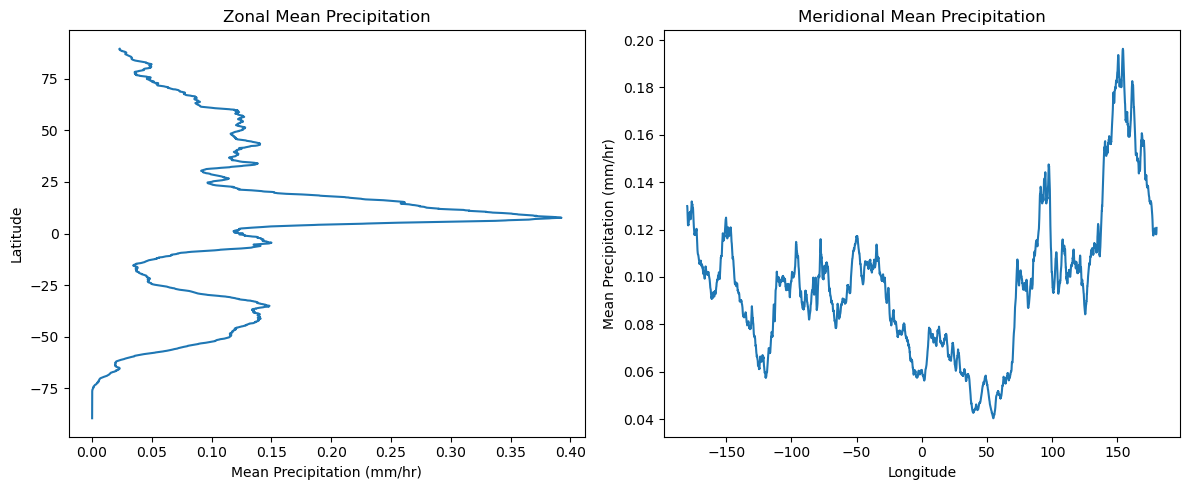

In [14]:
import matplotlib.pyplot as plt

# Calculate zonal (latitude-wise) and meridional (longitude-wise) means
zonal_mean = masked_precip.mean(axis=1)  # Mean across longitudes for each latitude
meridional_mean = masked_precip.mean(axis=0)  # Mean across latitudes for each longitude

# Plotting zonal and meridional means with actual lats and lons
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Zonal mean plot (latitude-wise mean)
ax1.plot(zonal_mean, theLats)
ax1.set_title("Zonal Mean Precipitation")
ax1.set_xlabel("Mean Precipitation (mm/hr)")
ax1.set_ylabel("Latitude")


# Meridional mean plot (longitude-wise mean)
ax2.plot(theLons, meridional_mean)
ax2.set_title("Meridional Mean Precipitation")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Mean Precipitation (mm/hr)")

plt.tight_layout()
plt.show()


#### Plot the data on a map

Now that we have the needed grids, let's plot the data on a map using matplotlib and cartopy.

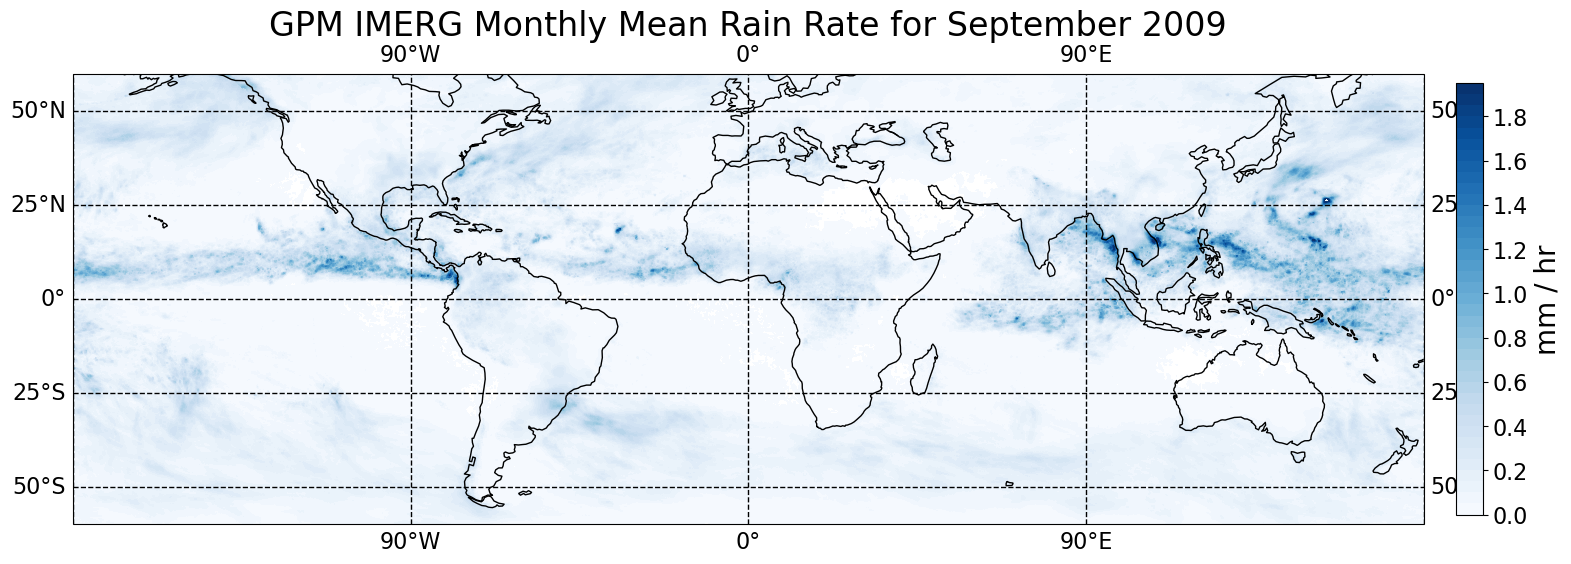

In [15]:
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(21,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180,180,-60,60])  

# Add coastlines and formatted gridlines
ax.coastlines(resolution="110m",linewidth=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
gl.ylocator = mticker.FixedLocator([-60, -50, -25, 0, 25, 50, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size':16, 'color':'black'}
gl.ylabel_style = {'size':16, 'color':'black'}

# Set contour levels and draw the plot
clevs = np.arange(0,2,0.05)
plt.contourf(x, y, precip, clevs, cmap=plt.cm.Blues)
plt.title('GPM IMERG Monthly Mean Rain Rate for September 2009', size=24)
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.set_label('mm / hr',size=20)
cb.ax.tick_params(labelsize=16)

**NOTICE** that the data is in units of mm/hr. To get the total rainfall for the month, we need to convert this to mm by multiplying by the total hours in the month. For example, for September (30 days), we would calculate:

In [16]:
# Total hours 
total_hours = 30 * 24

# Convert to total monthly rainfall (in mm)
total_monthly_precip = masked_precip * total_hours

Now let's recalculate basic **monthly** statistics

In [17]:
mean_monthly_precip = total_monthly_precip.mean()
max_monthly_precip = total_monthly_precip.max()
min_monthly_precip = total_monthly_precip.min()

print("Mean Monthly Precipitation:", mean_monthly_precip, "mm")
print("Max Monthly Precipitation:", max_monthly_precip, "mm")
print("Min Monthly Precipitation:", min_monthly_precip, "mm")


Mean Monthly Precipitation: 69.64290737589472 mm
Max Monthly Precipitation: 1970.6401634216309 mm
Min Monthly Precipitation: 0.0 mm


And then now let's recalculate the zonal and meridional means into monthly totals

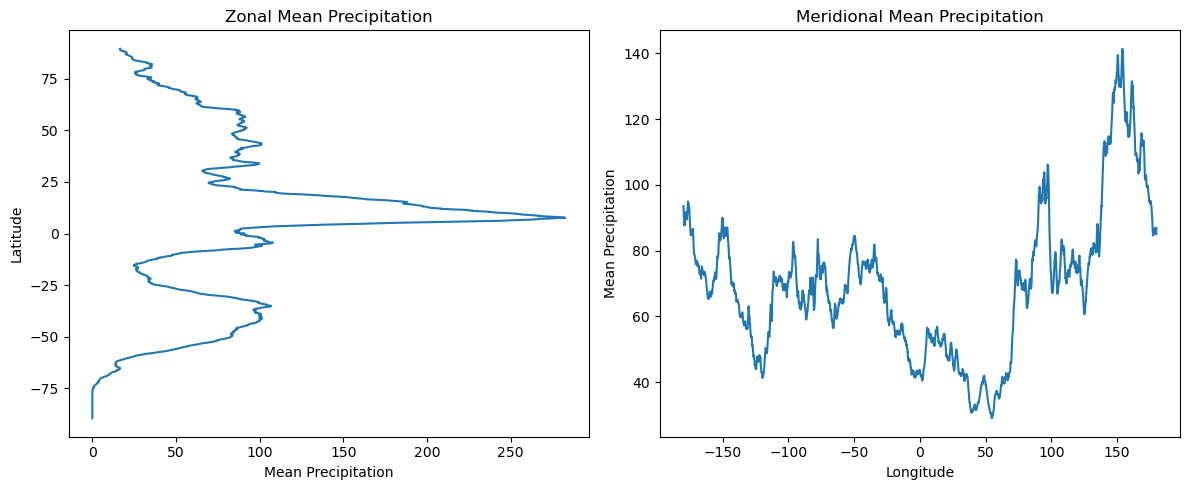

In [18]:
import matplotlib.pyplot as plt

# Calculate zonal (latitude-wise) and meridional (longitude-wise) means
zonal_mean = total_monthly_precip.mean(axis=1)  # Mean across longitudes for each latitude
meridional_mean = total_monthly_precip.mean(axis=0)  # Mean across latitudes for each longitude

# Plotting zonal and meridional means with actual lats and lons
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Zonal mean plot (latitude-wise mean)
ax1.plot(zonal_mean, theLats)
ax1.set_title("Zonal Mean Precipitation")
ax1.set_xlabel("Mean Precipitation")
ax1.set_ylabel("Latitude")


# Meridional mean plot (longitude-wise mean)
ax2.plot(theLons, meridional_mean)
ax2.set_title("Meridional Mean Precipitation")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Mean Precipitation")

plt.tight_layout()
plt.show()


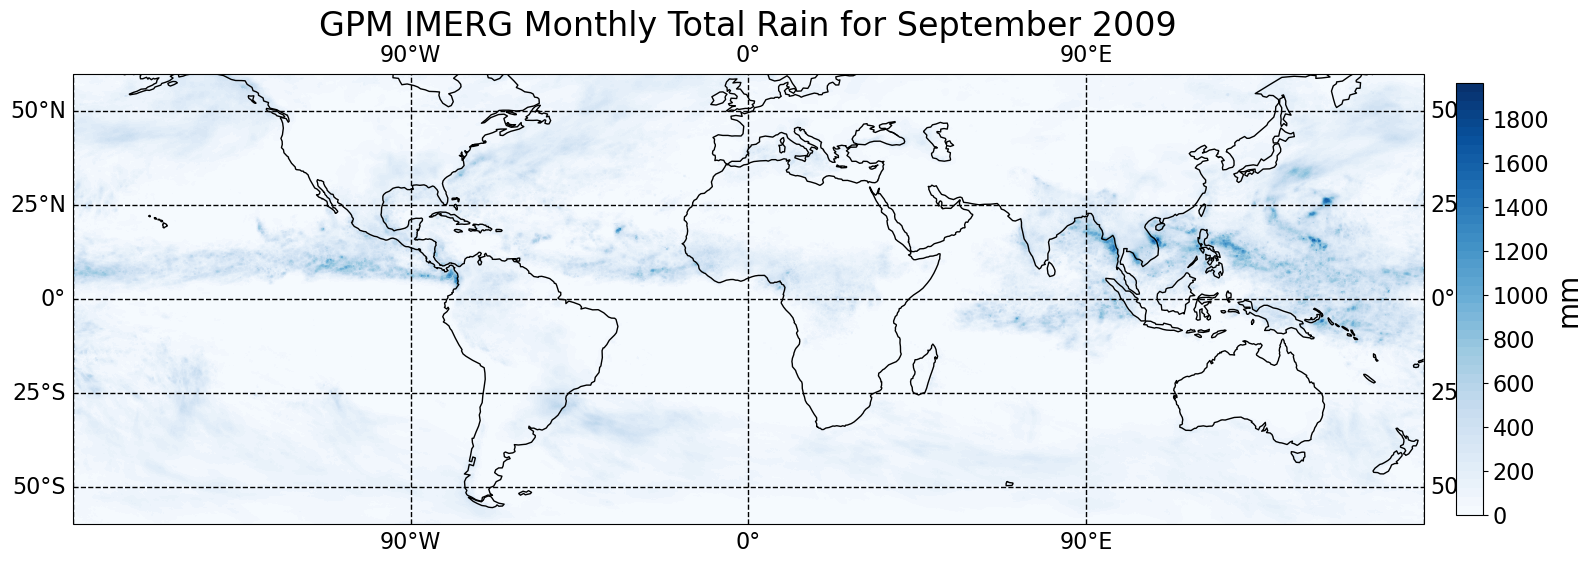

In [19]:
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(21,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180,180,-60,60])  

# Add coastlines and formatted gridlines
ax.coastlines(resolution="110m",linewidth=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
gl.ylocator = mticker.FixedLocator([-60, -50, -25, 0, 25, 50, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size':16, 'color':'black'}
gl.ylabel_style = {'size':16, 'color':'black'}

# Set contour levels and draw the plot
clevs = np.arange(0,2000,40)
plt.contourf(x, y, total_monthly_precip, clevs, cmap=plt.cm.Blues)
plt.title('GPM IMERG Monthly Total Rain for September 2009', size=24)
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.set_label('mm',size=20)
cb.ax.tick_params(labelsize=16)

To analyze precipitation data more closely over the Philippines, we can zoom in on that region by setting the map’s extent to the bounds covering the area. This way, we can focus on the spatial distribution of rainfall within the Philippines. Let's modify the `set_extent`.

C:\Users\alexg\miniconda3\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


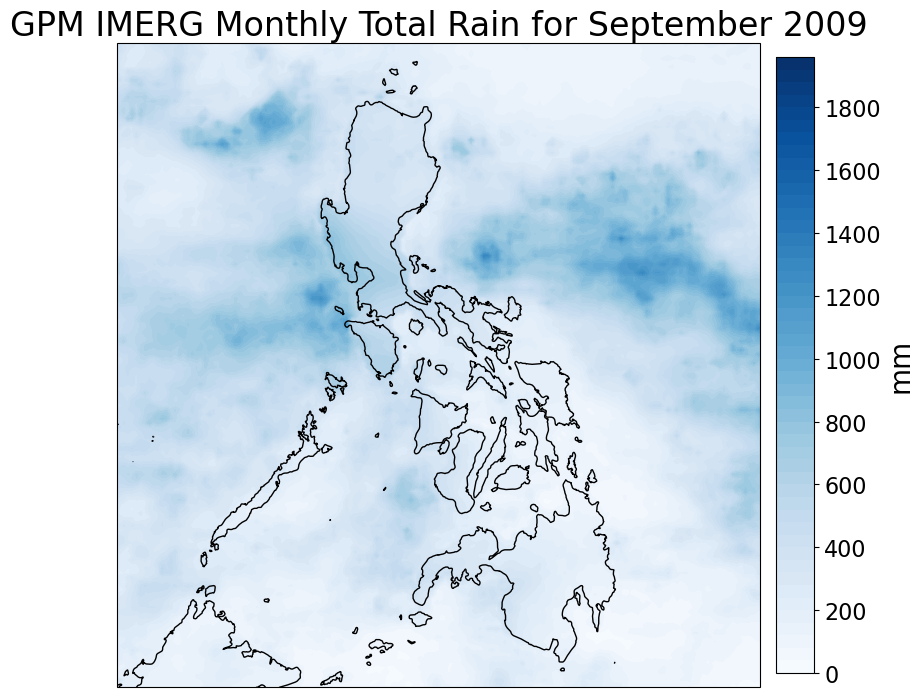

In [20]:
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([115, 130, 5, 20], crs=ccrs.PlateCarree())

# Add coastlines and formatted gridlines
ax.coastlines(resolution="10m",linewidth=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
gl.ylocator = mticker.FixedLocator([-60, -50, -25, 0, 25, 50, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size':16, 'color':'black'}
gl.ylabel_style = {'size':16, 'color':'black'}

# Set contour levels and draw the plot
clevs = np.arange(0,2000,40)
plt.contourf(x, y, total_monthly_precip, clevs, cmap=plt.cm.Blues)
plt.title('GPM IMERG Monthly Total Rain for September 2009', size=24)
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.set_label('mm',size=20)
cb.ax.tick_params(labelsize=16)

We can zoom in even further and adjust the colorbar.

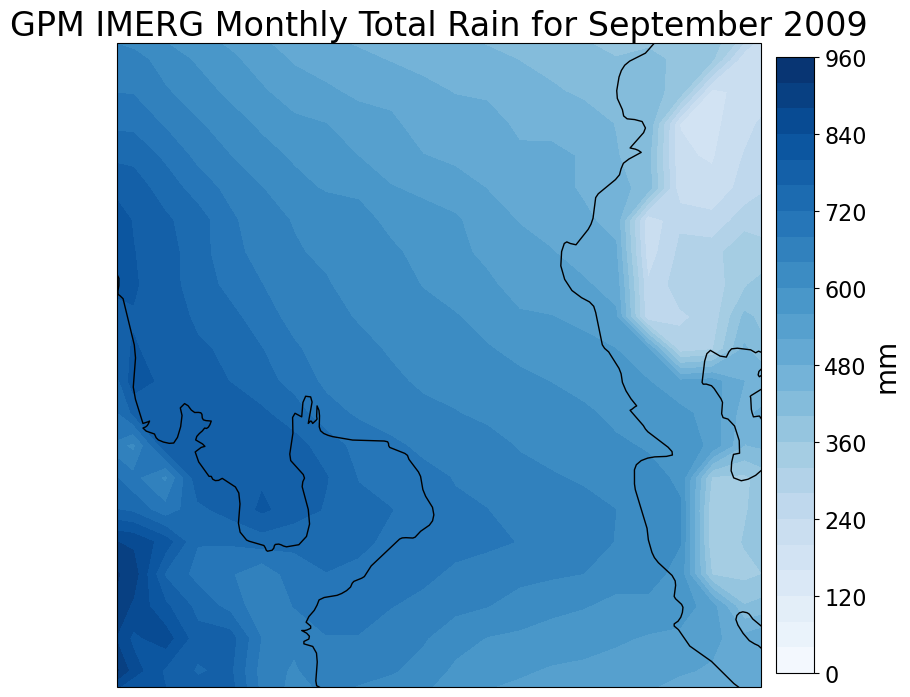

In [21]:
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([120, 122, 14, 16], crs=ccrs.PlateCarree())

# Add coastlines and formatted gridlines
ax.coastlines(resolution="10m",linewidth=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
gl.ylocator = mticker.FixedLocator([-60, -50, -25, 0, 25, 50, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size':16, 'color':'black'}
gl.ylabel_style = {'size':16, 'color':'black'}

# Set contour levels and draw the plot
clevs = np.arange(0,1000,40)
plt.contourf(x, y, total_monthly_precip, clevs, cmap=plt.cm.Blues)
plt.title('GPM IMERG Monthly Total Rain for September 2009', size=24)
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.set_label('mm',size=20)
cb.ax.tick_params(labelsize=16)

Notice how smooth the data is? It's because we're currently plotting using `contourf`. This is often used for plotting continuous data, like rainfall, because it smooths the data between defined levels, filling the contours with colors that represent different precipitation values. This technique is useful for highlighting broad patterns in data, making it easier to interpret areas with higher or lower values visually. However, `contourf` doesn’t directly show the gridded structure, which may be desirable for some analyses.

`pcolormesh` is another option, especially useful when you want to emphasize the grid structure of the data. Unlike `contourf`, `pcolormesh` does not interpolate between values and instead displays each grid cell individually, revealing the data's actual resolution and granularity. Take note that `pcolormesh` requires different arguments, which are pre-filled below.

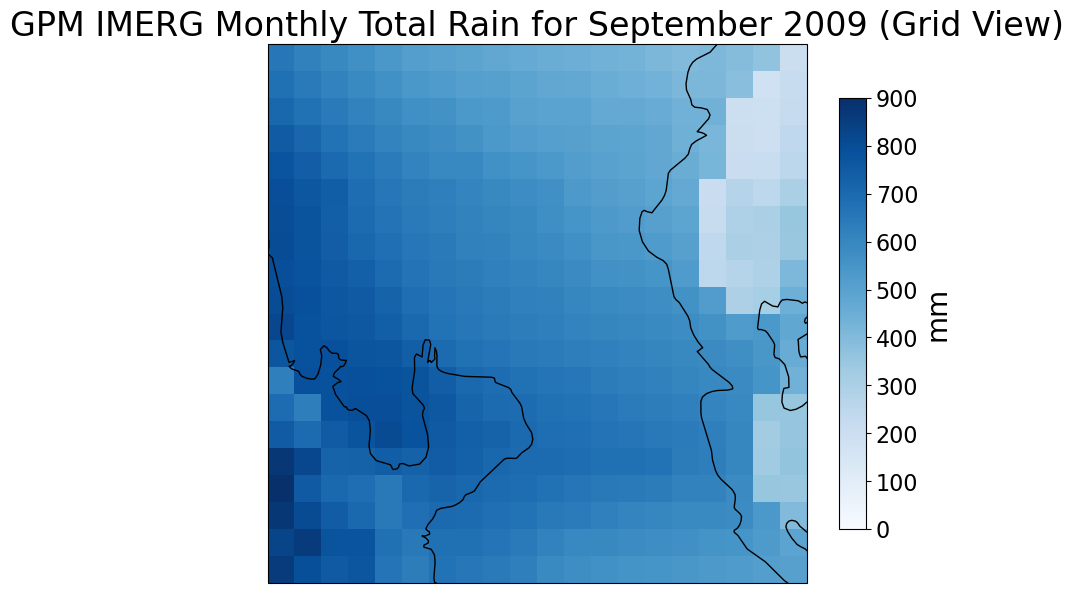

In [22]:
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(21, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([120, 122, 14, 16], crs=ccrs.PlateCarree())

# Add coastlines and formatted gridlines
ax.coastlines(resolution="10m", linewidth=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
gl.ylocator = mticker.FixedLocator([-60, -50, -25, 0, 25, 50, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'}

# Plot using pcolormesh to show the gridded nature of the data
plt.pcolormesh(x, y, total_monthly_precip, cmap=plt.cm.Blues, shading='auto', transform=ccrs.PlateCarree(), vmin=0, vmax=900)
plt.title('GPM IMERG Monthly Total Rain for September 2009 (Grid View)', size=24)
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.set_label('mm', size=20)
cb.ax.tick_params(labelsize=16)

plt.show()
